# pixels2diagram

In [1]:
def spiral(n_cups):
    """
    Implements the asymptotic worst-case for normal_form, see arXiv:1804.07832.
    """
    x = Ty('x')
    unit, counit = Box('unit', Ty(), x), Box('counit', x, Ty())
    cup, cap = Box('cup', x @ x, Ty()), Box('cap', Ty(), x @ x)
    for box in [unit, counit, cup, cap]:
        box.draw_as_spider, box.color, box.drawing_name = True, "red", ""
    result = unit
    for i in range(n_cups):
        result = result >> Id(x ** i) @ cap @ Id(x ** (i + 1))
    result = result >> Id(x ** n_cups) @ counit @ Id(x ** n_cups)
    for i in range(n_cups):
        result = result >>\
            Id(x ** (n_cups - i - 1)) @ cup @ Id(x ** (n_cups - i - 1))
    return result

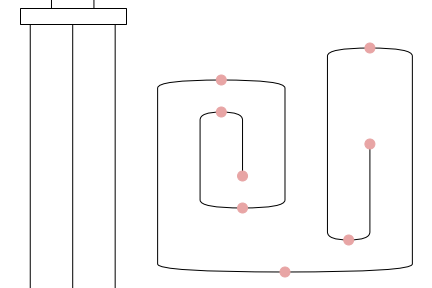

In [2]:
from discopy import *
from PIL import Image

diagram = Box('f', Ty('x', 'x'), Ty('x', 'x', 'x'))\
    @ spiral(3)
rewrites = list(diagram.normalize())
diagram = rewrites[21]

params = dict(
    draw_type_labels=False,
    draw_as_nodes=True,
    draw_box_labels=False,
    margins=(0.05, 0))

diagram.draw(**params, path='../_static/imgs/test-pixels2diagram.png')
img = Image.open('../_static/imgs/test-pixels2diagram.png')
img

In [3]:
import numpy as np

arr = np.array(img)
print("height, width, [red, blue, green, opacity]: {}".format(arr.shape))

height, width, [red, blue, green, opacity]: (288, 432, 4)


Found 8 boxes:


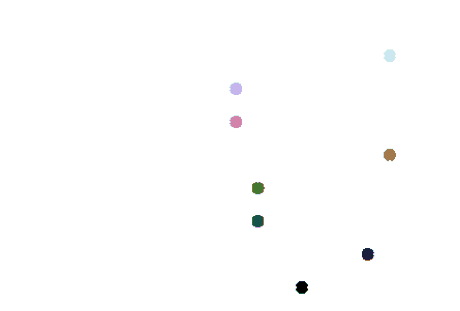

In [4]:
from skimage import measure
from matplotlib import pyplot as plt


threshold = 200
red = np.logical_and(arr[:, :, 0] > threshold,
                     arr[:, :, 1] < threshold,
                     arr[:, :, 2] < threshold)
box_pixels, n_boxes = measure.label(red, return_num=True)
print("Found {} boxes:".format(n_boxes))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(-box_pixels, cmap='cubehelix')
plt.show()

Found 8 wires:


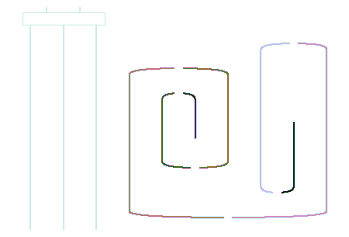

In [5]:
wire_pixels, n_wires = measure.label(arr[:, :, 0] < threshold, return_num=True)
print("Found {} wires:".format(n_wires))

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(-wire_pixels, cmap='cubehelix')
plt.show()

In [6]:
box_properties = measure.regionprops(box_pixels)
wire_properties = measure.regionprops(wire_pixels)

critical_heights = np.array(
    [0] + [box['centroid'][0] for box in box_properties] + [arr.shape[0]])

def find_start_and_endpoints(wire):
    start = np.argmin(np.abs(critical_heights - wire['coords'][0][0]))
    end = np.argmin(np.abs(critical_heights - wire['coords'][-1][0]))
    return (start, end)

print("Connectivity (wires to boxes [1, ..., 9] or boundary [0, 10]):")
wires_to_boxes = {i: find_start_and_endpoints(wire) for i, wire in enumerate(wire_properties)}
wires_to_boxes

Connectivity (wires to boxes [1, ..., 9] or boundary [0, 10]):


{0: (0, 9),
 1: (1, 7),
 2: (1, 8),
 3: (2, 8),
 4: (2, 6),
 5: (3, 6),
 6: (3, 5),
 7: (4, 7)}

In [7]:
print("Connectivity (boxes/boundary to wires):")
boxes_to_wires = {i: ([wire for wire, (_, end) in wires_to_boxes.items() if end == i],
                      [wire for wire, (start, _) in wires_to_boxes.items() if start == i])
                  for i, _ in enumerate(critical_heights)}
boxes_to_wires

Connectivity (boxes/boundary to wires):


{0: ([], [0]),
 1: ([], [1, 2]),
 2: ([], [3, 4]),
 3: ([], [5, 6]),
 4: ([], [7]),
 5: ([6], []),
 6: ([4, 5], []),
 7: ([1, 7], []),
 8: ([2, 3], []),
 9: ([0], [])}

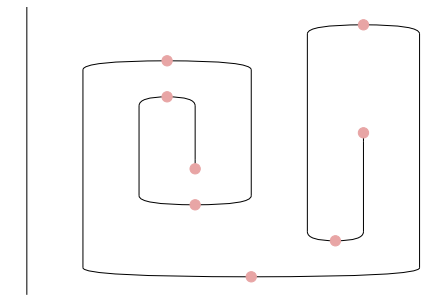

In [8]:
scan = boxes_to_wires[0][1]
result = Id(PRO(len(scan)))
for i, box_data in enumerate(box_properties):
    inputs, outputs = boxes_to_wires[i + 1]
    depth, width = map(int, box_data['centroid'])
    offset = len(set(wire_pixels[depth, :width]) - {wire + 1 for wire in inputs + outputs}) - 1
    box = Box('box_{}'.format(i), PRO(len(inputs)), PRO(len(outputs)), draw_as_spider=True)
    result = result\
        >> Id(PRO(offset)) @ box @ Id(PRO(len(scan) - len(inputs) - offset))
    scan = scan[:offset] + outputs + scan[offset + len(inputs):]
result.draw(**params)